<a href="https://colab.research.google.com/github/Pragalbhv/atomai/blob/master/examples/notebooks/EarlyStopping_HRTEM_pv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Early stopping Demo 2: HRTEM dataset

This is a short demo for the improved AtomAI model. The model has several additions. such as
- Early stopping
- Automatic binary thresholding
- Weight Decay

The data contains HRTEM images of Au and CdSe nanoparticles along with manually marked image-maps.

In [1]:
# !pip install setuptools==65.5.0 wheel==0.38.4 #run this cell incase there is trouble in installing the Github package

Install the latest AtomAI version with additional features such as

- Early stopping
- Auto-thresholding
- Weight decay

In [2]:
!pip install git+https://github.com/Pragalbhv/atomai # install the latest version from source

  Cloning https://github.com/Pragalbhv/atomai to /tmp/pip-req-build-4u3hkw7s
  Running command git clone --filter=blob:none --quiet https://github.com/Pragalbhv/atomai /tmp/pip-req-build-4u3hkw7s
  Resolved https://github.com/Pragalbhv/atomai to commit 96b42566f8dc2c5e9641fa0f87ab7e660a2c8620
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.3 MB/s eta 0:00:00
  Created wheel for atomai: filename=atomai-0.7.8.1.1-py3-none-any.whl size=164642 sha256=e28344c068987209d3d78eca3b11a183ccbcf915270cd9427df4bdf0b6009076
  Stored in directory: /tmp/pip-ephem-wheel-cache-b5m7172a/wheels/8a/cd/d6/cae2c72d6a960d0bd3bcb5b857772ee2d0c639b720e8e0aab8
  Created wheel 

In [3]:
# import all necessay libraries.
from atomai.utils import create_lattice_mask, extract_patches_
from atomai.transforms import datatransform
import numpy as np
import h5py

import atomai as aoi
from atomai.transforms import datatransform

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

The following function, download_HRTEM_files, loads data files based on the user's choice of mode and provides options for 'Au', 'CdSe', and 'combined'.

### Following options are availabe for loading:-
- Au
- CdSe
- combined

In [4]:
def download_HRTEM_files(mode:str ='Au'):
  '''
  Loads the necessay files for the demo depending on user's choice.
  The following Modes are available:
  - Au
  - CdSe
  - combined
  '''
  assert mode in ['Au','CdSe','combined'], "Mode must be either 'Au','CdSe', or 'combined' "


  # Load Au dataset
  if mode=='Au':
    #load images
    download_link = 'https://drive.google.com/uc?id=12HvjJJUbGYELZ_aX5d2NM91DRnNQtSvi'
    !gdown $download_link -O 'images.h5'

    #load image maps
    download_link = 'https://drive.google.com/uc?id=1OahENi8mbeX9RybnT2xY-I4psBZmQ1GF'
    !gdown $download_link -O 'maps.h5'

    number_images=215


  # Load CdSe dataset
  elif mode=='CdSe':
    #load images
    download_link = 'https://drive.google.com/uc?id=18pU8wdZ7oDV7IiUo7aSGfWIKpCmi2fUt'
    !gdown $download_link -O 'images.h5'

    #load image maps
    download_link = 'https://drive.google.com/uc?id=1OsXg82Lc3Ci-7H-RQCwUCvu-ifZwiUsd'
    !gdown $download_link -O 'maps.h5'

    number_images=172

  # Load combined dataset
  else:
    #load images
    download_link = 'https://drive.google.com/uc?id=1aQHdYMyOcTobedw7vnG7udzWFLVbyV44'
    !gdown $download_link -O 'images.h5'

    #load image maps
    download_link = 'https://drive.google.com/uc?id=1a8hu5Utns5yAGe0rQNi7cpswHopl90yJ'
    !gdown $download_link -O 'maps.h5'

    number_images=257


  #loading Au HRTEM file
  with h5py.File('images.h5', 'r') as f:
    data = f.get('images')[()]
  with h5py.File('maps.h5') as f:
    data2 = f.get('maps')[()]

  def remove_empty(threshold=10):
    clean_imgs=[]
    clean_labels=[]
    for img,label in zip(data,data2):
        if np.sum(label[:,:,1])>threshold:
            clean_imgs.append(img)
            clean_labels.append(label)
    return clean_imgs,clean_labels
  imgs,lbls_re=remove_empty()

  ### number of images in file
  # - Au: 216 [215 non-zero]
  # - CdSe: 172
  # - Au & CdSe: 258


  imgs_re0=np.reshape(imgs,(number_images,512,512)) #reshape according to number of images in the file
  lbls_re0=np.array(lbls_re)

  imgs_re,_ , lbls_re,_ = train_test_split(imgs_re0,lbls_re0,test_size=43) # Keep 43 samples in test nishavirag!!!
  X_train_pre, X_test_pre, y_train_pre, y_test_pre=train_test_split(imgs_re,lbls_re,test_size=43,random_state=42) #hitch a hike to the galxy!!!


  # Preparing for the test dataset
  X_test=np.reshape(X_test_pre,(43,1,512,512)) #reshaping to atomai's spcifications
  y_test=np.zeros((43,512,512))

  y_test[y_test_pre[:,:,:,0] == 1] = 0
  y_test[y_test_pre[:,:,:,1] == 1] = 1

  return X_train_pre, y_train_pre, X_test, y_test









In [5]:
X_train_pre, y_train_pre, images_test, labels_test =download_HRTEM_files('Au')

Downloading...
From: https://drive.google.com/uc?id=12HvjJJUbGYELZ_aX5d2NM91DRnNQtSvi
To: /content/images.h5
100% 453M/453M [00:03<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OahENi8mbeX9RybnT2xY-I4psBZmQ1GF
To: /content/maps.h5
100% 906M/906M [00:10<00:00, 89.9MB/s]


The following two functions perform data augmentation and generate the training and the validation set

In [6]:
def imgen(rotat=True, mode="contrast"):
  '''
  To assist multimodal dataaugmentation. user can specify their own mode.
  Uses the datatransform module alone
  '''
  ch = 2



  if mode=="contrast":
      imaug=datatransform(
          n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',rotation=rotat,
          contrast=True,squeeze_channels=True)

  if mode=="blur":
      imaug = datatransform(
      n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first', rotation=rotat,
      blur=True,squeeze_channels=True)

  if mode=='gauss_noise':
      imaug = datatransform(
      n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first', rotation=rotat,
      gauss_noise=True,squeeze_channels=True)

  if mode=='background':
      imaug = datatransform(
      n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first', rotation=rotat,
      background=True,squeeze_channels=True)
  if mode=='rotat':
      imaug=datatransform(
          n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',rotation=rotat,
          squeeze_channels=True)



  imm,lbb=X_train_pre,y_train_pre

  lbb = lbb[..., None] if np.ndim(lbb) == 3 else lbb

  images_all, labels_all = imaug.run(imm, lbb)
  return images_all, labels_all





In [7]:
def imagesmake(mode='contrast'):
  print(mode)

  max_epochs=5
  image_fin,lbl_fin=imgen(rotat=True,mode=mode)
  image_fin_full=image_fin
  lbl_fin_full=lbl_fin
  for epoch in range(max_epochs-1):
      image_fin,lbl_fin=imgen(rotat=True,mode=mode)
      image_fin_full=np.concatenate((image_fin_full,image_fin))
      lbl_fin_full=np.concatenate((lbl_fin_full,lbl_fin))
      print('Datapoints created:'+str(len(lbl_fin_full)), end='\r')
  return image_fin_full, lbl_fin_full

In [8]:
image_fin,lbl_fin=imagesmake('blur') #prints te total number of images produced

blur


In [9]:
images, images_val, labels, labels_val=train_test_split(image_fin,lbl_fin, test_size=0.2, random_state=42) #splitting train and validation set

In [10]:
del X_train_pre, y_train_pre, image_fin, lbl_fin #remove extraneous variables

In [11]:
print(images.shape, labels.shape)
print(images_val.shape, labels_val.shape)
print(images_test.shape, labels_test.shape)
# look at shape of images and labels(maps)

(516, 1, 512, 512) (516, 512, 512)
(129, 1, 512, 512) (129, 512, 512)
(43, 1, 512, 512) (43, 512, 512)


Let's plot some of the training data:

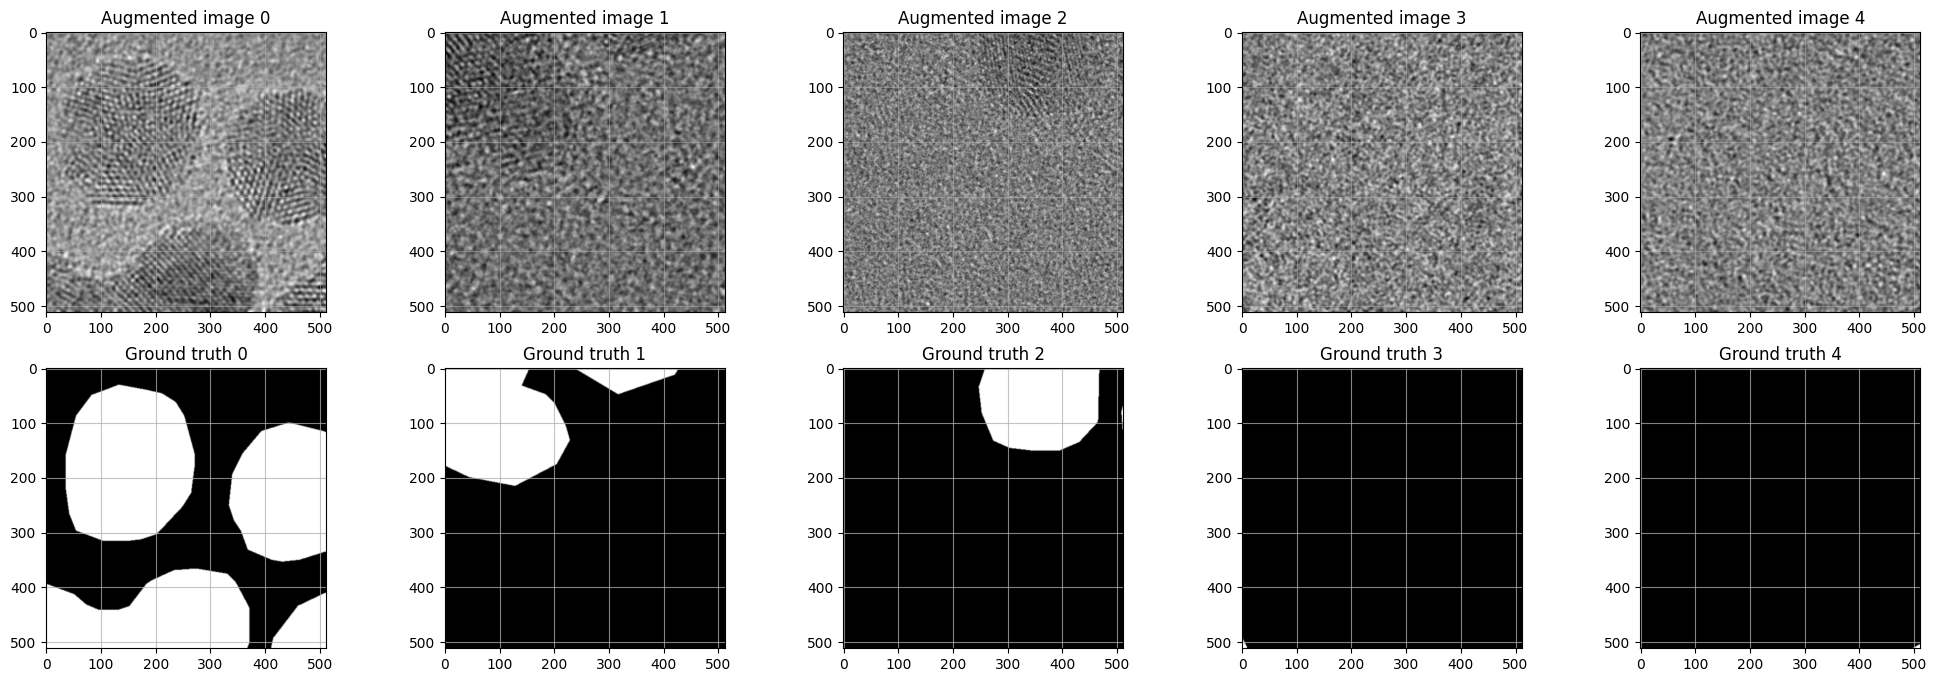

In [12]:
n = 5
k=1
n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1+k,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    if labels.shape[1] == 1:
        ax.imshow(labels[i-1+k, 0], cmap='gray', interpoltion='Gaussian')
    else:
        ax.imshow(labels[i-1+k], cmap='gray', interpolation='Gaussian')


    ax.set_title('Ground truth ' + str(i-1))
    ax.grid(alpha=0.75)

Initialize a nodel for semantic segmentation:

In [13]:
model = aoi.models.Segmentor(nb_classes=1) #load model with 1 class (positive class: atom)

In [14]:
print(model.net)

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Train the initialized model:

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

## The model has multiple additional features:
- **auto_thresh (bool):
        Performs automatic binary threshold selection for optimal f1-score
- **ES (bool):
        Early stopping mode on/off
- **patience (int):
         patience for early stopping
- **tolerance (float):
         tolerance for early stopping
- **weight_decay (float):
          weight decay for model

# Early stopping:
- The implemented Early stopping module has a few related kwargs. These can be set by the user.

- Stochastic weight averaging is not implemented for Early stopping Model, so it must be set to false, else ES will not run.

- Tolerance is how much minimum improvement is necessary to be considered as an improvement.

- Paitence is how many epochs the model runs for without improvement before terminating. This is done in an attempt to prevent the model settling in a local minima, and resulting in sub-par performance



/usr/local/lib/python3.10/dist-packages/atomai/utils/preproc.py:64: UserWarning: Adding a channel dimension of 1 to training labels
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/atomai/utils/preproc.py:69: UserWarning: Adding a channel dimension of 1 to test labels
  warnings.warn(


Epoch 1/3000 ... Training loss: 0.8193 ... Test loss: 0.7136 ... Train Accuracy: 0.1769 ... Test Accuracy: 0.189 ... GPU memory usage: 11471/15360
Updating ES model @ Epoch 1/3000 ... Training loss: 0.8193 ... Test loss: 0.7136 ... Train Accuracy: 0.1769 ... Test Accuracy: 0.189 ... GPU memory usage: 11471/15360
Updating ES model @ Epoch 2/3000 ... Training loss: 0.7276 ... Test loss: 0.7132 ... Train Accuracy: 0.2869 ... Test Accuracy: 0.189 ... GPU memory usage: 11473/15360
Updating ES model @ Epoch 3/3000 ... Training loss: 0.7026 ... Test loss: 0.7096 ... Train Accuracy: 0.3506 ... Test Accuracy: 0.2016 ... GPU memory usage: 11473/15360
Updating ES model @ Epoch 5/3000 ... Training loss: 0.6208 ... Test loss: 0.6964 ... Train Accuracy: 0.5035 ... Test Accuracy: 0.2414 ... GPU memory usage: 11473/15360
Updating ES model @ Epoch 9/3000 ... Training loss: 0.5902 ... Test loss: 0.6904 ... Train Accuracy: 0.527 ... Test Accuracy: 0.4236 ... GPU memory usage: 11473/15360
Updating ES mode

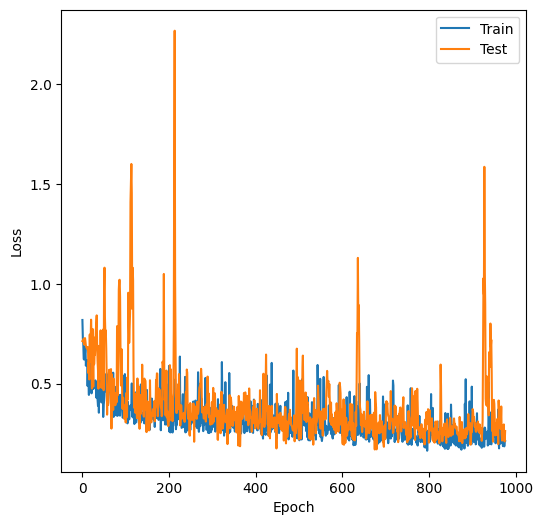

Calculating Automatic Threshold
Batch 129/129
129 images were decoded in approximately 3.3697 seconds


In [15]:
#fitting the model
model.fit(images, labels, images_val, labels_val, # training data
          training_cycles=3000, compute_accuracy=True, batch_size=16, swa=False, filename='ES_reg',
          ES=True, patience=300,tolerance=1e-4,verbose=True,auto_thresh=True)
# In AtomAI by default the validation set is also evaluated on mini-batch. Set full_epoch=True if you want validation error to be reported for the full validation set (preferred when ES=True).
#model.fit(images, labels, images_val, labels_val, # training data
#          training_cycles=3000, compute_accuracy=True, batch_size=16, swa=False, filename='ES_reg',
#          ES=True, patience=50,tolerance=1e-4,verbose=True,auto_thresh=False, full_epoch=True)


In the reusability report article the parameters training cycles and patience are set to 5000 and 500, respectively. The number of augmented images were ~ 2500. In this example notebooks, the parameters like training cycles, patience, number of augmented images created are modified to run without any premium GPU resources. This is done for “EarlyStopping_LBFO_pv.ipynb" as well.

# Thresholding
We shall take a look at automatic thresholding here.
Once the model is trained on the dataset, the holdout dataset is passed to it. The model then predicts k probabilities for each class for each pixel. These probability values can be 'thresholded' at various values, i.e, the class k is predicted if and only if $$I\!P(k)>= \theta$$
where $\theta$, is the threshold value.

\\
In the context of thresholding, when the threshold value (represented as $\theta$) is set to 0.5, it is considered the standard value. This threshold corresponds to 1/k, where k is equal to 2, representing the number of classes. According to this standard threshold, an instance is classified as positive if its probability is above 0.5.


\\
When the threshold $\theta$ is set to a lower value, even the slightest probability is sufficient for an instance to be classified as a positive instance of the class. This results in an increase in recall, but it also leads to a decrease in precision.

\\
Conversely, when the threshold $\theta$ is set to a larger value, only instances with significantly high probabilities are classified as positive. This higher threshold value reduces recall since some true positive instances may now fall below the threshold. However, it increases precision as the selected positive instances are more likely to be true positives.

## Automatic threshold setting

By setting the ```auto_thresh``` kwarg to True, automatic binary threshold  for optimal f1-score is selected with respect to holdout-set ```images_val```. The threshold maximises the threshold with respect to the holdout set, which we use as validation set, and then predict on the test set  ```images_test``` which is not provided to the model.

In [16]:
'''
The following value of threshold maximizes the f-1 score over  images_val.
Note the threshold if different from the default 0.5.

'''
model.binary_thresh

0.3

# Predictions:

Predict on ```images_test``` using the model, using the threshold found by automatic thresholding

In [17]:
# model=aoi.load_model('ES_reg_metadict_final.tar')# we can load the model from saved file as well, which has the best binary thrshold saved

In [18]:
pred_auto=model.predict(images_test) #auto thresholding

Performing auto-thresh prediction
Batch 43/43
43 images were decoded in approximately 1.0902 seconds


In [19]:
pred_user=model.predict(images_test,thresh=0.5) #user can provide threshold as well, here the predictions are in standard AtomAI format

Batch 43/43
43 images were decoded in approximately 0.9999 seconds


In [20]:
pred_auto[-1] #auto pred has an additional channel with class predictions for given best threshold. this is only produced by automatic thresholding

array([[[1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 0., 1., 1.]],

       [[1., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 1.]],

       [[1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 0., 1.

Auto-thresholding has three channels;
with the last channel providing the class labels for the best threshold

Auto-thresholding is currently only implemented for binary-class
